In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [284]:
restaurant_data = pd.read_csv('../RestoInfo.csv')

In [285]:
restaurant_data.head(3)

,Unnamed: 0,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,46019,Unique Brew Cafe Resto,No,No,NaN,0,Indiranagar,Quick Bites,NaN,Fast Food,200,[],[],Dine-out,Old Airport Road
1,28849,Jayanthi Sagar,No,No,3.1 /5,21,Koramangala 5th Block,Quick Bites,NaN,"South Indian, North Indian, Chinese",200,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out,Koramangala 4th Block
2,19855,Rock Stone Ice Cream Factory,Yes,No,4.0/5,131,BTM,Dessert Parlor,"Icecream Cake, Brownie, Waffles, Chocolate Ice...",Ice Cream,230,"[('Rated 4.0', ""RATEDn Ice creams are really ...","['Midnight Indulgence Cake', 'Butterscotch Mel...",Delivery,Jayanagar


In [290]:
restaurant_data.dtypes

id                   int64
name                object
online_order        object
book_table          object
rate                object
votes                int64
location            object
rest_type           object
dish_liked          object
cuisines            object
cost_of_two        float64
reviews_list        object
menu_item           object
listed_in(type)     object
listed_in(city)     object
dtype: object

# Data Cleaning

In [306]:
# Renaming the Unnamed: 0 column to id
restaurant_data = restaurant_data.rename(columns={'Unnamed: 0': 'id', 'approx_cost(for two people)':'cost_of_two'})
restaurant_data['cost_of_two'] = restaurant_data['cost_of_two'].astype('str').str.replace(',', '').apply(lambda x: float(x))
restaurant_data['location'] = restaurant_data['location'].str.strip()
restaurant_data['name'] = restaurant_data['name'].str.strip()
restaurant_data.dtypes

id                   int64
name                object
online_order        object
book_table          object
rate                object
votes                int64
location            object
rest_type           object
dish_liked          object
cuisines            object
cost_of_two        float64
reviews_list        object
menu_item           object
listed_in(type)     object
listed_in(city)     object
dtype: object

# PreProcessing of Cuisines and Dish Liked

In [307]:
restaurant_data.isnull().sum(axis=0)

id                    0
name                  0
online_order          0
book_table            0
rate                299
votes                 0
location              0
rest_type            17
dish_liked         1107
cuisines              0
cost_of_two          16
reviews_list          0
menu_item             0
listed_in(type)       0
listed_in(city)       0
dtype: int64

In [308]:
# Stack the cuisines
cuisine_stacked = (pd.DataFrame(restaurant_data[['id', 'cuisines']].set_index('id').cuisines.str.split(',').tolist(), 
                                index=restaurant_data['id'])
                   .stack().reset_index().rename(columns={0:'cuisines'})[['id', 'cuisines']])

# Merge the stacked dataframe with restaurant data
restaurant_data_stacked = (restaurant_data.merge(cuisine_stacked, 
                                         how='inner', on='id', 
                                         suffixes=('_original', '_stacked'))
                   .drop('cuisines_original', axis=1).rename(columns={'cuisines_stacked':'cuisines'}))

dish_data = restaurant_data[['id', 'dish_liked']].dropna()

dish_stacked = (pd.DataFrame(dish_data.set_index('id').dish_liked.str.split(',').tolist(), index=dish_data['id'])
                .stack().reset_index().rename(columns={0:'dish_liked'})[['id', 'dish_liked']])

restaurant_data_stacked = (restaurant_data_stacked.merge(dish_stacked, 
                                                         how='left', on='id', suffixes=('_original', '_stacked'))
                           .drop('dish_liked_original', axis=1).rename(columns={'dish_liked_stacked':'dish_liked'}))

restaurant_data_stacked['cuisines'] = restaurant_data_stacked['cuisines'].str.strip()
restaurant_data_stacked['dish_liked'] = restaurant_data_stacked['dish_liked'].str.strip()
restaurant_data_stacked.head(3)

,id,name,online_order,book_table,rate,votes,location,rest_type,cost_of_two,reviews_list,menu_item,listed_in(type),listed_in(city),cuisines,dish_liked
0,46019,Unique Brew Cafe Resto,No,No,NaN,0,Indiranagar,Quick Bites,200.0,[],[],Dine-out,Old Airport Road,Fast Food,NaN
1,28849,Jayanthi Sagar,No,No,3.1 /5,21,Koramangala 5th Block,Quick Bites,200.0,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out,Koramangala 4th Block,South Indian,NaN
2,28849,Jayanthi Sagar,No,No,3.1 /5,21,Koramangala 5th Block,Quick Bites,200.0,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out,Koramangala 4th Block,North Indian,NaN


# Summary Statistics

In [309]:
restaurant_data_stacked.nunique()

id                 2069
name               1665
online_order          2
book_table            2
rate                 55
votes               588
location             82
rest_type            64
cost_of_two          46
reviews_list       1698
menu_item           483
listed_in(type)       7
listed_in(city)      30
cuisines             81
dish_liked         1158
dtype: int64

**There are 2069 Restaurant Outlets in the Dataset. Out of them we have 1665 Restaurant Brands which fall under 64 unique restaurant types. We have 82 different locations in Bangalore where the restaurants in the dataset are spread over. There are 139 different cuisines available in the dataset that are offered by various restaurants. We have 1362 different dishes that are liked by the customers in different restaurants.**

# Top Most Foodie Locations in Bangalore

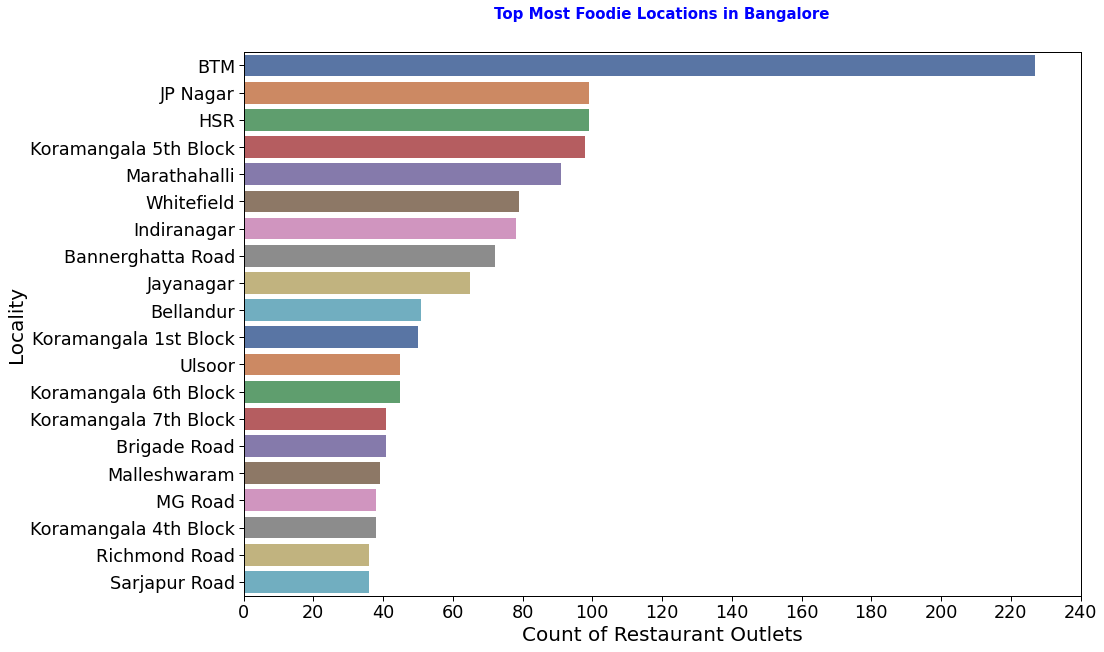

In [214]:
plt.figure(figsize=(15, 10))
location_foodie = restaurant_data['location'].value_counts()[:20]
xticks = [i for i in range(location_foodie[0]+20) if i%20==0]
sns.barplot(x=location_foodie, y=location_foodie.index, palette='deep')
plt.xlabel('Count of Restaurant Outlets')
plt.ylabel('Locality')
plt.title('Top Most Foodie Locations in Bangalore', color='blue', fontsize='15', weight='bold', position=[0.5, 1.05])
plt.xticks(xticks)
plt.show()

**The Localities BTM, Jp Nagar, HSR & Koramangala 5th Block are the most foodie areas with more than 100 Restaurants**

# Top Most Restaurant Types

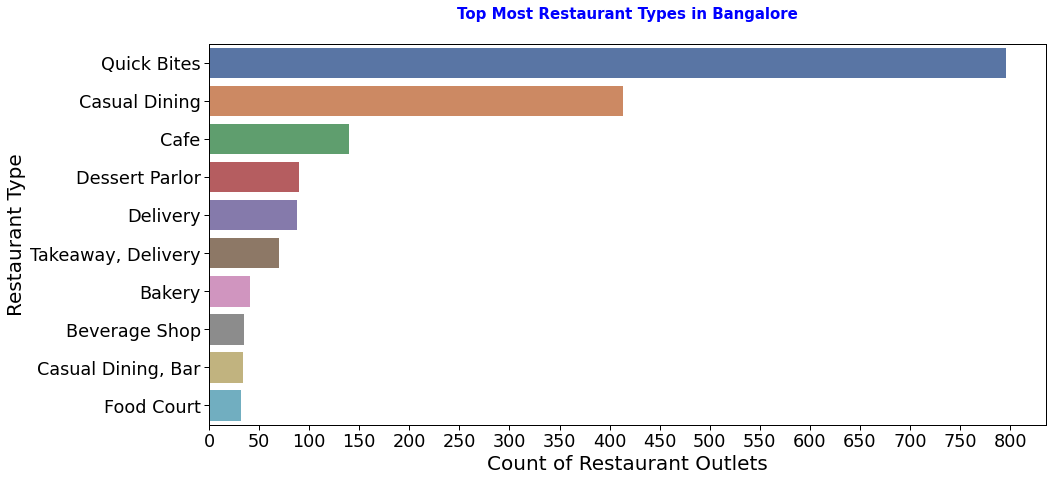

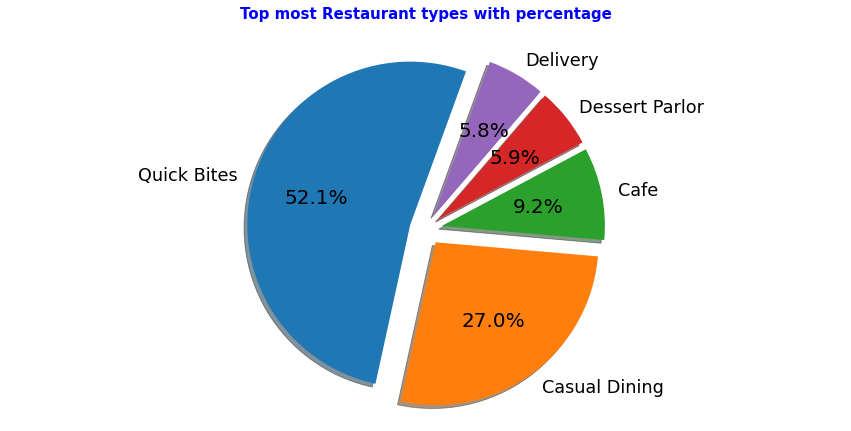

In [215]:
plt.figure(figsize=(15, 7))
location_foodie = restaurant_data['rest_type'].value_counts()[:10]
xticks = [i for i in range(location_foodie[0]+50) if i%50==0]
sns.barplot(x=location_foodie, y=location_foodie.index, palette='deep')
plt.xlabel('Count of Restaurant Outlets')
plt.ylabel('Restaurant Type')
plt.title('Top Most Restaurant Types in Bangalore', color='blue', fontsize=15, weight='bold', position=[0.5, 1.05])
plt.xticks(xticks)
plt.show()

# A Pie Chart can better represent this graph as below

plt.figure(figsize=(15, 7))
colors = ['#800080','red','#00FFFF','#FFFF00','#00FF00','#FF00FF']
explode = [0.1]*5  # explode 1st slice
plt.title('Top most Restaurant types with percentage', weight = 'bold', fontsize=15, color='blue', position=[0.5, 1.05])
plt.pie(location_foodie.values[:5], explode=explode, labels=location_foodie.index[:5],autopct='%1.1f%%', shadow=True, startangle=70)
plt.axis('equal')
plt.show()

**Out of 64 different types of restaurants in the dataset, the top most restaurant type is Quick Bites with 52% of restaurants followed by Casual Dining with 27%. 79% of the restaurants are of type Quick Bites and Casual Dining and 21% of other 62 restaurant types.**

# Proportion of Online Delivering Restaurants

Yes    1221
No      848
Name: online_order, dtype: int64


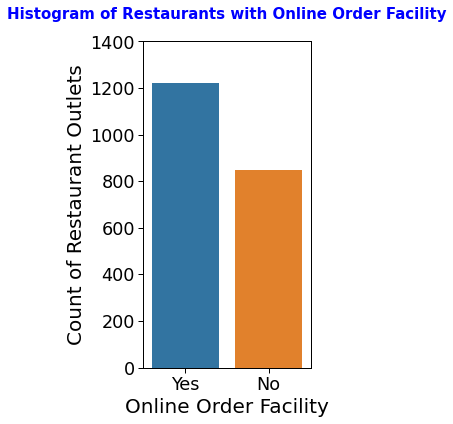

In [216]:
plt.figure(figsize=(3, 6))
delivery_status = restaurant_data['online_order'].value_counts()
print(delivery_status)
yticks=[i for i in range(delivery_status[0]+200) if i%200==0]
sns.barplot(y=delivery_status, x=delivery_status.index)
plt.xlabel('Online Order Facility')
plt.ylabel('Count of Restaurant Outlets')
plt.title('Histogram of Restaurants with Online Order Facility', fontsize=15, weight='bold', color='blue', position=[0.5, 1.05])
plt.yticks(yticks)
plt.show()

**There are 1221 restaurants i.e. 59% that accept online orders i.e. home delivery and 848 i.e. 41% restaurants that do not accept online orders. In our above restaurant type analysis we found that 52% of quick bites restaurants and 27% of casual dining restaurants.**

**Both these distributions seems logical because there is high chance that a quick bites restaurant types would provide online order services compared to casual dining types where there is least chance.Further analysis of Quick Bites and Casual Dining restaurants is done later.**

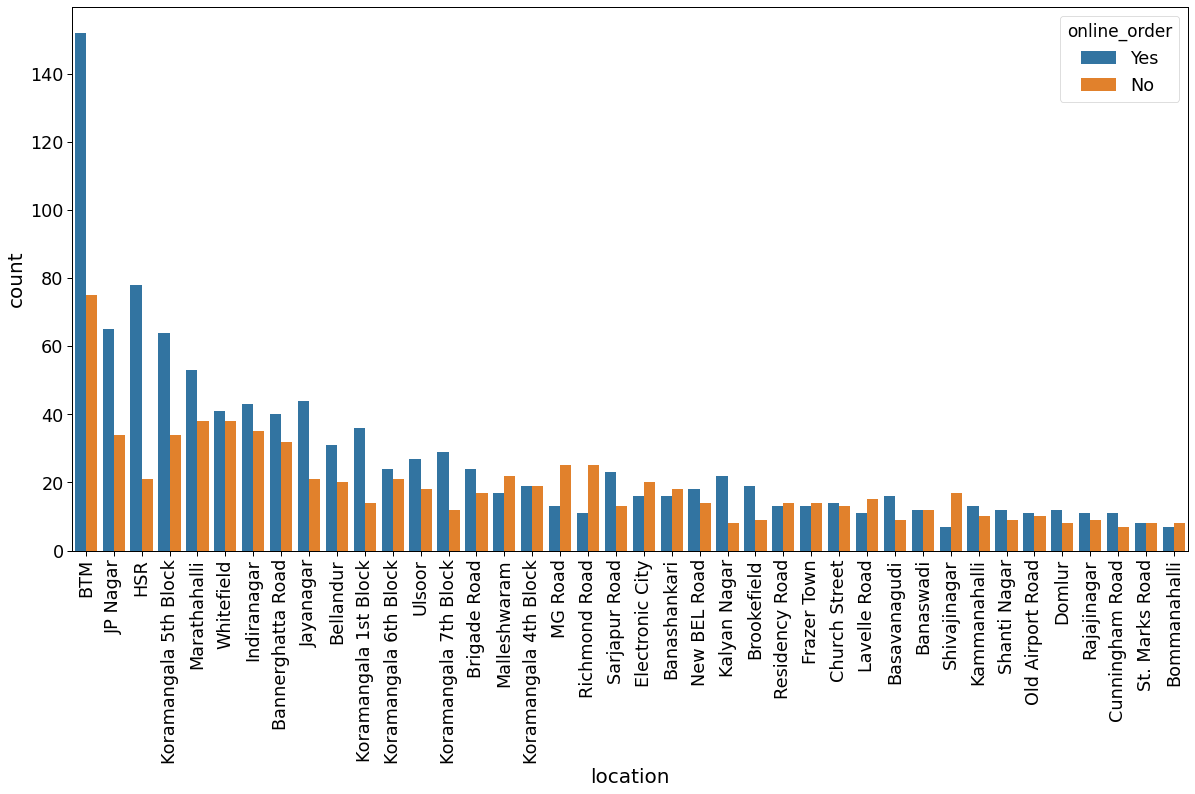

In [217]:
plt.figure(figsize=(20, 10))
location_wise_delivery = restaurant_data[['id', 'online_order', 'location']]
location_wise_delivery = (location_wise_delivery.merge(location_wise_delivery
                                                       .groupby('location')['id'].agg(['count'])
                                                       .reset_index()
                                                       .sort_values('count', ascending=False)[:40], 
                                                       how='inner', on='location').sort_values('count', ascending=False))
sns.countplot(data=location_wise_delivery, x='location', hue='online_order')
plt.xticks(rotation=90)
plt.show()

**Most of the top foodie locality restaurants have more percentage of restaurants that accept online orders. BTM, JP Nagar, HSR, Koramangala 5th Block have majority of restaurants in their locality that accept online orders. Few exceptional places like MG Road, Richmond Road & Electronic City have less proportion of restaurants in their locality that accept online orders.**

# Proportion of PreBooking Facilitated Restaurants

No     1810
Yes     259
Name: book_table, dtype: int64


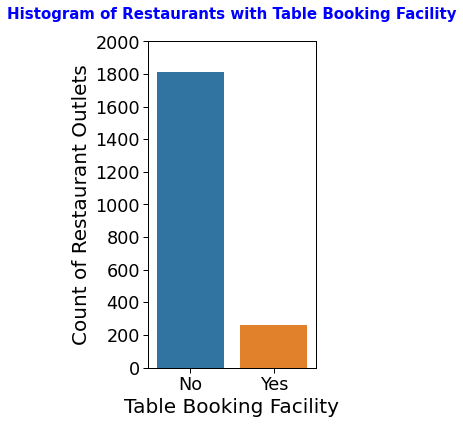

In [218]:
plt.figure(figsize=(3, 6))
delivery_status = restaurant_data['book_table'].value_counts()
print(delivery_status)
yticks=[i for i in range(delivery_status[0]+200) if i%200==0]
sns.barplot(y=delivery_status, x=delivery_status.index)
plt.xlabel('Table Booking Facility')
plt.ylabel('Count of Restaurant Outlets')
plt.title('Histogram of Restaurants with Table Booking Facility', fontsize=15, weight='bold', color='blue', position=[0.5, 1.05])
plt.yticks(yticks)
plt.show()

**Only 12% of restaurants provide pre booking of table facility. It is logical as table bookings are usually done by families, team lunch parties by corporates or large friends group. This type of events occur very rare. According to our analysis done in the previous sections, most of the restaurants serve orders online and would just maintain kitchen. Hence most of the restaurants do not provide table booking.**

# Top Most Restaurant Brand in Bangalore

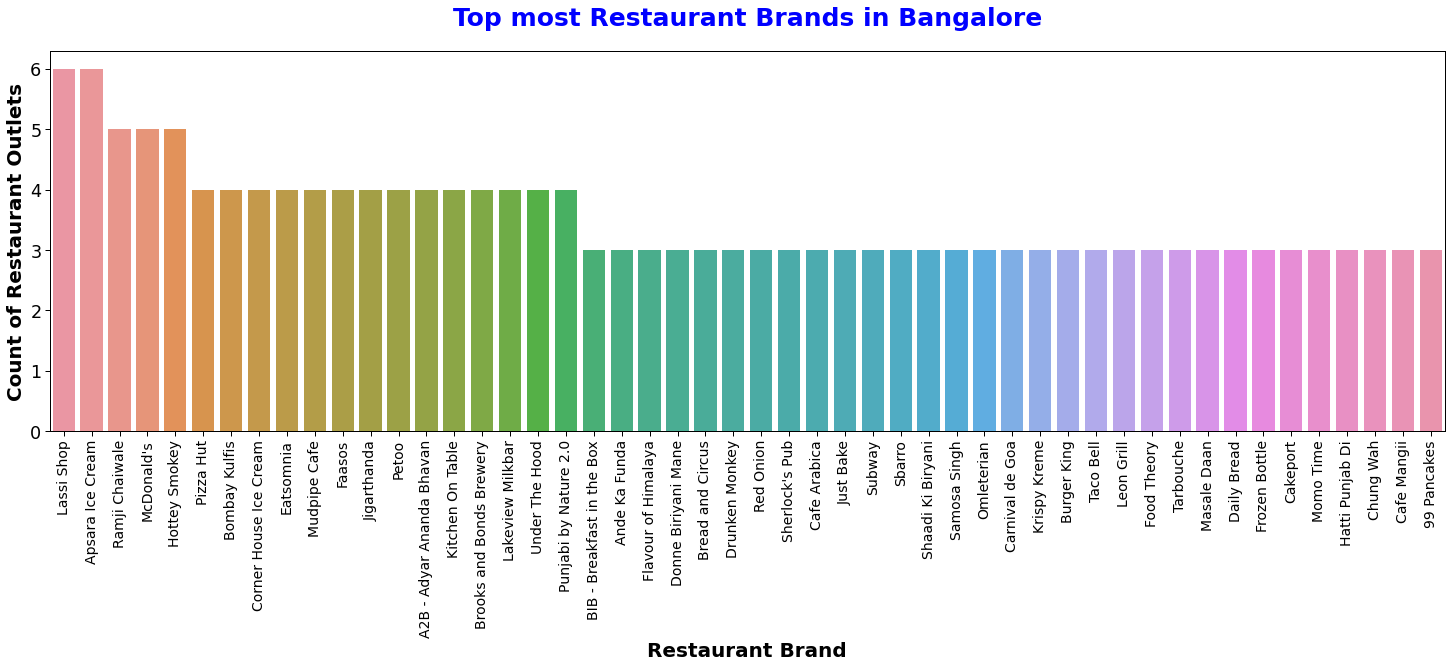

In [219]:
plt.figure(figsize=(25, 7))
restaurant_outlets = restaurant_data['name'].value_counts()[:50]
sns.barplot(x=restaurant_outlets.index, y=restaurant_outlets)
plt.ylabel('Count of Restaurant Outlets', fontsize=20, weight='bold')
plt.xlabel('Restaurant Brand', fontsize=20, weight='bold')
plt.xticks(rotation=90, fontsize=14)
plt.title('Top most Restaurant Brands in Bangalore', color='blue', weight='bold', fontsize=25, position=[0.5, 1.05])
plt.show()

**The number of outlets of restaurant brands are not much diverse. Lassi Shop & Apsara Ice Cream is the highest with 6 outlets. McDonald's, HotteySmokey,RamjiChaiwale are the next highest with 5 outlets. Brooks&Bonds is the Brewery with highest outlets of value 4 compared to Sherlock's pub which has 3 outlets**  

# What are the Costly Restaurant Localities

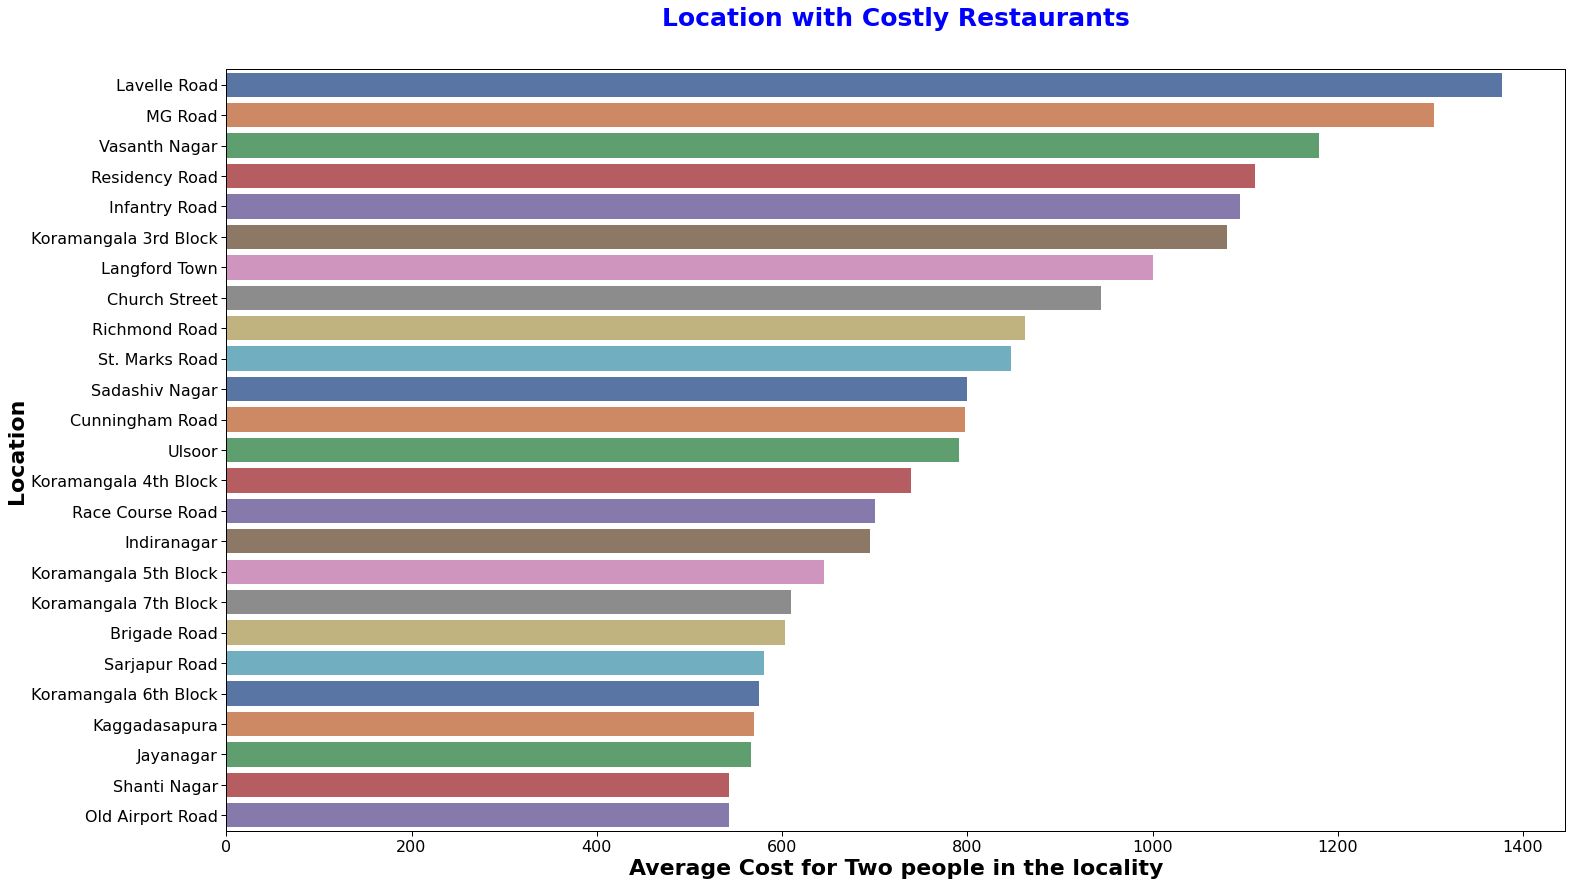

In [264]:
plt.figure(figsize=(24, 14))
location_cost = (restaurant_data[['location', 'cost_of_two']]
                 .dropna().groupby(['location'])['cost_of_two'].agg(['mean'])
                 .sort_values(['mean'], ascending=False)[:25])

sns.barplot(x=location_cost['mean'], y=location_cost.index, palette='deep')
plt.xlabel('Average Cost for Two people in the locality', fontsize=22, weight='bold')
plt.ylabel('Location', fontsize=22, weight='bold')
plt.yticks(fontsize=16, color='black')
plt.xticks(fontsize=16, color='black')
plt.title('Location with Costly Restaurants', fontsize=25, color='blue', weight='bold', position=[0.5, 1.05])
plt.show()

**The Localities Lavelle Road or Commercial Street has the costly restaurants with nearly Rs 1400 for two followed by MG Road with nearly Rs1300 for two. Other areas like Vasanth Nagar, Residency Road, Church Street & Koramangala 3rd Block are the costly places in Bangalore.**

# Popular Cuisines

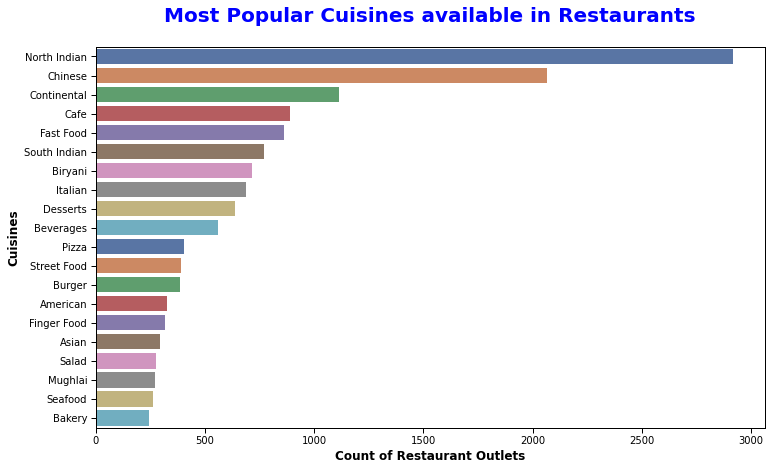

In [311]:
plt.figure(figsize=(12, 7))
chains = restaurant_data_stacked['cuisines'].value_counts(ascending=False)[:20]
sns.barplot(x=chains, y=chains.index, palette='deep')
plt.xlabel('Count of Restaurant Outlets', fontsize=12, weight='bold')
plt.ylabel('Cuisines', fontsize=12, weight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Most Popular Cuisines available in Restaurants', fontsize=20, color='blue', position=[0.5, 1.05], weight='bold')
plt.show()

**The top most cuisines offered by bangalore restaurants are North India, Chinese & Continental food. Suprisingly being in a south indian state, the number of South Indian cuisine restaurants are almost 1/3rd of North Indian cuisine restaurants. Cafe and Fast Food are also the most available cuisines in the restaurants**

# Most Liked & Least Liked Dishes

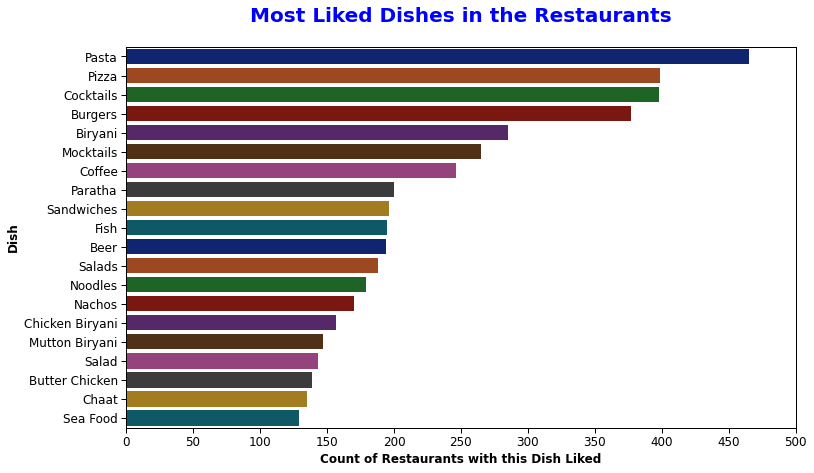

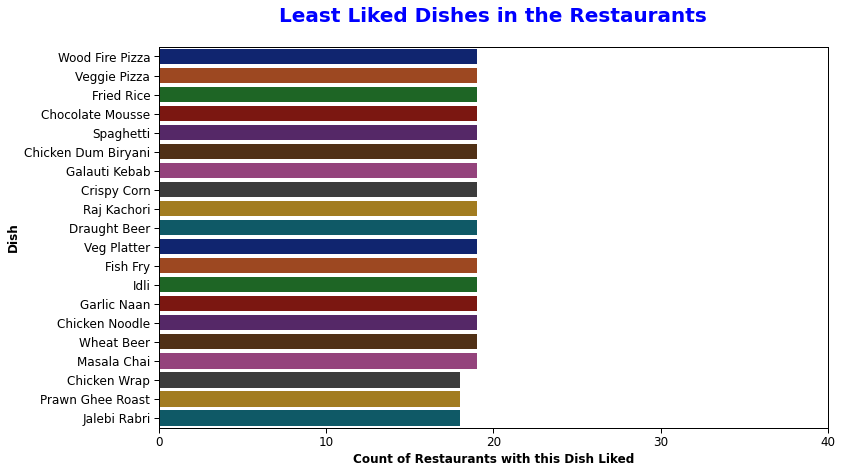

In [345]:
plt.figure(figsize=(12, 7))
dish_liked = restaurant_data_stacked['dish_liked'].value_counts()[:20]
sns.barplot(x=dish_liked, y=dish_liked.index, palette='dark')
xticks = [i for i in range(dish_liked[0]+50) if i%50==0]
plt.xlabel('Count of Restaurants with this Dish Liked', fontsize=12, weight='bold')
plt.ylabel('Dish', fontsize=12, weight='bold')
plt.xticks(xticks, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Most Liked Dishes in the Restaurants', fontsize=20, color='blue', position=[0.5, 1.05], weight='bold')
plt.show()
plt.figure(figsize=(12, 7))
dish_liked = restaurant_data_stacked['dish_liked'].value_counts()
dish_disliked = dish_liked[dish_liked.values < 20][:20]
sns.barplot(x=dish_disliked, y=dish_disliked.index, palette='dark')
xticks = [i for i in range(50) if i%10==0]
plt.xlabel('Count of Restaurants with this Dish Liked', fontsize=12, weight='bold')
plt.ylabel('Dish', fontsize=12, weight='bold')
plt.xticks(xticks, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Least Liked Dishes in the Restaurants', fontsize=20, color='blue', position=[0.5, 1.05], weight='bold')
plt.show()

**The most liked dishes in bangalore restaurants is Pasta & Pizza. Burgers, Biryani & Paratha are the next most liked items. In case of beverages & mixed drinks Cocktails is most liked drink followed by Mocktails & Coffee.** 

**As a heuristic I have considered that an item is least liked if it is liked less than 20 times. The dataset can be improved by merging dishes like Wood Fire Pizza, Veggie Pizza to Pizza dish and Chicken Dum Biryani to Biryani dish. Ignoring them the least popular dishes are Fried Rice, Spaghetti & Idli.**

# Most Liked & Least Liked Dishes Online

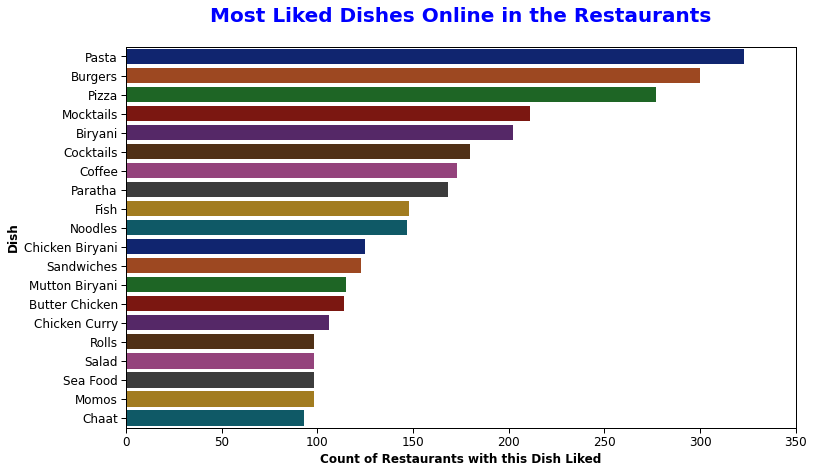

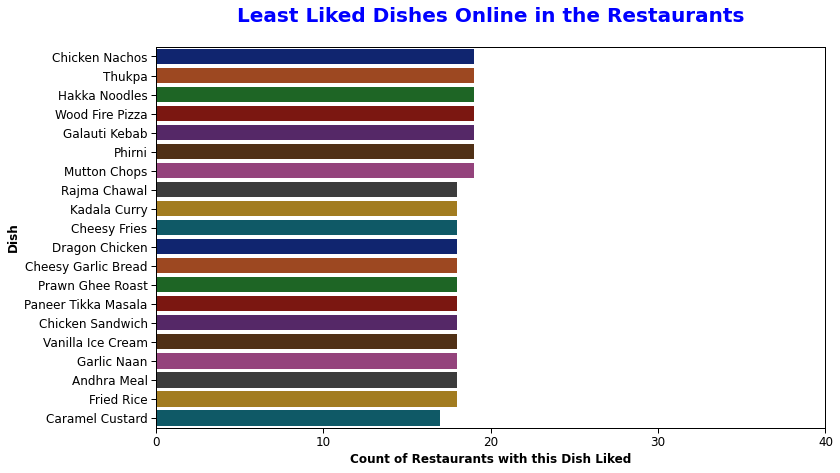

In [347]:
plt.figure(figsize=(12, 7))
dish_liked = restaurant_data_stacked[restaurant_data_stacked['online_order']=='Yes']['dish_liked'].value_counts()[:20]
sns.barplot(x=dish_liked, y=dish_liked.index, palette='dark')
xticks = [i for i in range(dish_liked[0]+50) if i%50==0]
plt.xlabel('Count of Restaurants with this Dish Liked', fontsize=12, weight='bold')
plt.ylabel('Dish', fontsize=12, weight='bold')
plt.xticks(xticks, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Most Liked Dishes Online in the Restaurants', fontsize=20, color='blue', position=[0.5, 1.05], weight='bold')
plt.show()
plt.figure(figsize=(12, 7))
dish_liked = restaurant_data_stacked[restaurant_data_stacked['online_order']=='Yes']['dish_liked'].value_counts()
dish_disliked = dish_liked[dish_liked.values < 20][:20]
sns.barplot(x=dish_disliked, y=dish_disliked.index, palette='dark')
xticks = [i for i in range(50) if i%10==0]
plt.xlabel('Count of Restaurants with this Dish Liked', fontsize=12, weight='bold')
plt.ylabel('Dish', fontsize=12, weight='bold')
plt.xticks(xticks, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Least Liked Dishes Online in the Restaurants', fontsize=20, color='blue', position=[0.5, 1.05], weight='bold')
plt.show()

# Distribution of Ratings

In [10]:
def removeJunk(x):
    try:
        return float(x)
    except ValueError:
        pass

In [11]:
plt.figure(figsize=(10, 7))
ratings = restaurant_data['rate'].dropna().apply(lambda x: x.split('/')[0]).apply(removeJunk)
ratings.head(5)

1    3.1
2    4.0
3    4.2
4    3.9
5    4.1
Name: rate, dtype: float64

<Figure size 720x504 with 0 Axes>

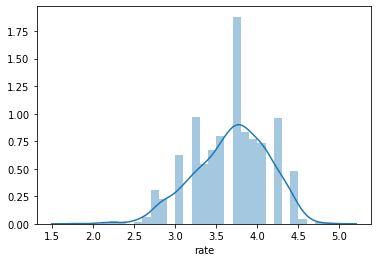

In [12]:
sns.distplot(ratings)

# Restaurant Ratings

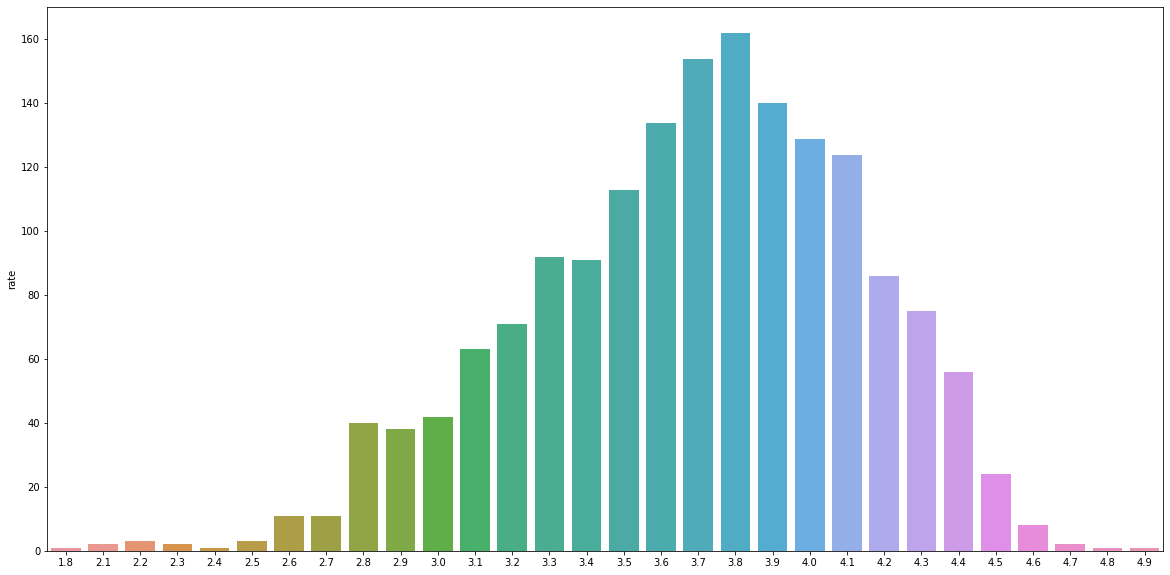

In [13]:
plt.figure(figsize=(20, 10))
ratings_count = ratings.value_counts()
sns.barplot(x=ratings_count.index, y=ratings_count)

In [14]:
online_status=restaurant_data['online_order'].value_counts()
booking_status = restaurant_data['book_table'].value_counts()

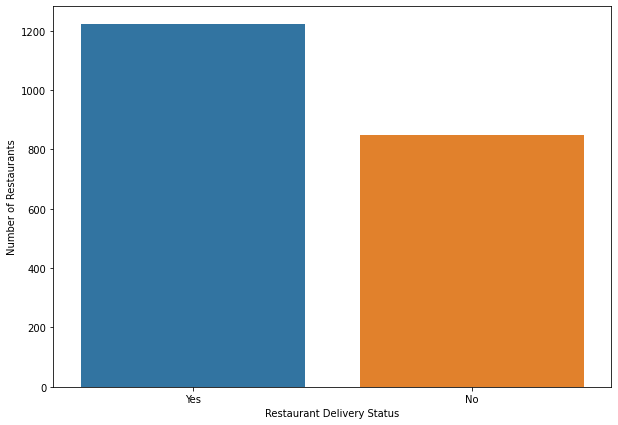

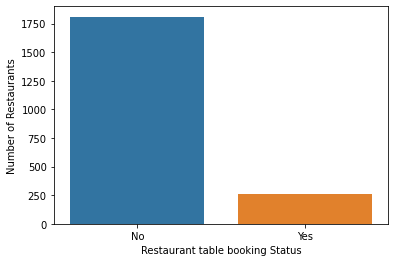

In [15]:
plt.figure(figsize=(10,7))
online_plot = sns.barplot(x=online_status.index, y=online_status)
plt.xlabel('Restaurant Delivery Status')
plt.ylabel('Number of Restaurants')
plt.show()
booking_plot = sns.barplot(x=booking_status.index, y=booking_status)
plt.xlabel('Restaurant table booking Status')
plt.ylabel('Number of Restaurants')
plt.show()

# Popular Dishes Liked

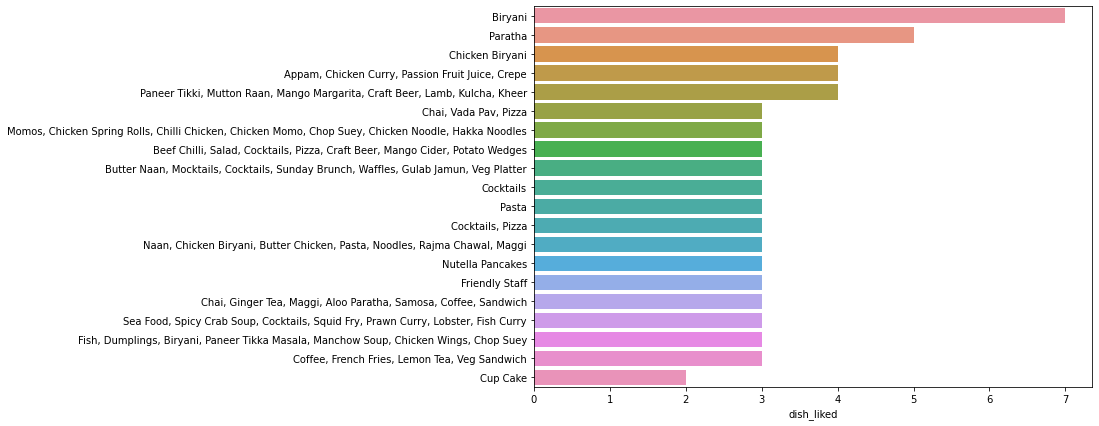

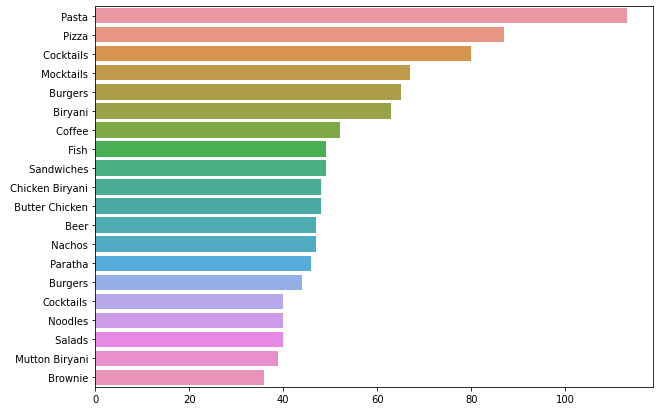

In [16]:
plt.figure(figsize=(10, 7))
dish_liked = restaurant_data['dish_liked'].dropna()
dish_liked = dish_liked.value_counts()[:20]
sns.barplot(x=dish_liked, y=dish_liked.index)
plt.show()
plt.figure(figsize=(10, 7))
dish_liked = restaurant_data['dish_liked'].dropna()
dish_liked = pd.DataFrame(dish_liked.str.split(',').tolist()).stack()
dish_liked = dish_liked.reset_index(drop=True)
dish_liked = dish_liked.value_counts()[:20]
sns.barplot(x=dish_liked, y=dish_liked.index)
plt.show()

# Votes & Rating Analysis

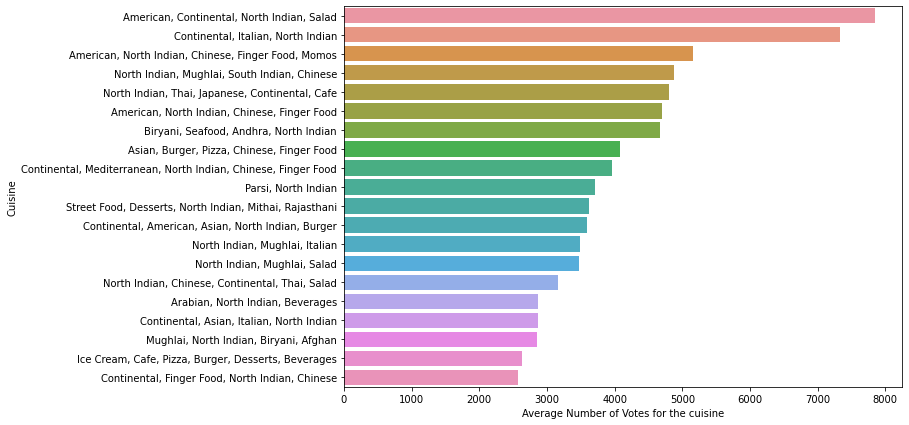

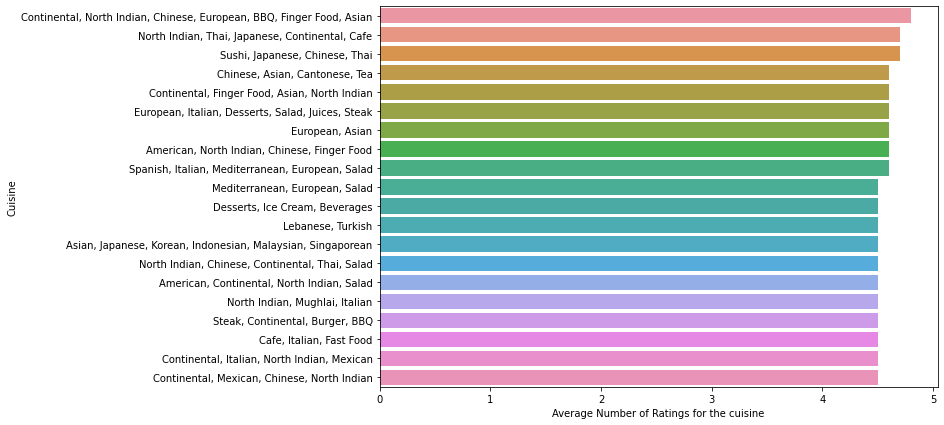

In [17]:
plt.figure(figsize=(10,7))
cuisine_votes = restaurant_data.groupby(['cuisines'])['votes'].agg(['mean']).sort_values(['mean'], ascending=False)[:20]
sns.barplot(x=cuisine_votes['mean'], y=cuisine_votes.index)
plt.xlabel('Average Number of Votes for the cuisine')
plt.ylabel('Cuisine')
plt.show()
plt.figure(figsize=(10, 7))
cuisine_ratings = restaurant_data[['cuisines', 'rate']].dropna()
cuisine_ratings['rate'] = cuisine_ratings['rate'].apply(lambda x: x.split('/')[0]).apply(removeJunk)
cuisine_ratings = cuisine_ratings.groupby('cuisines')['rate'].agg(['mean']).sort_values(['mean'], ascending=False)[:20]
sns.barplot(x=cuisine_ratings['mean'], y=cuisine_ratings.index)
plt.xlabel('Average Number of Ratings for the cuisine')
plt.ylabel('Cuisine')
plt.show()

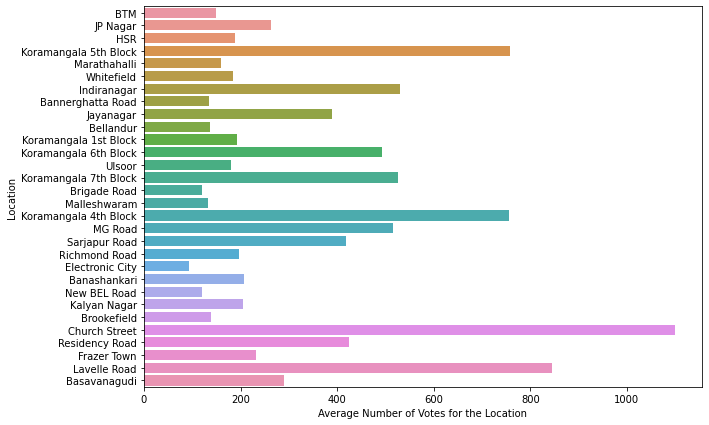

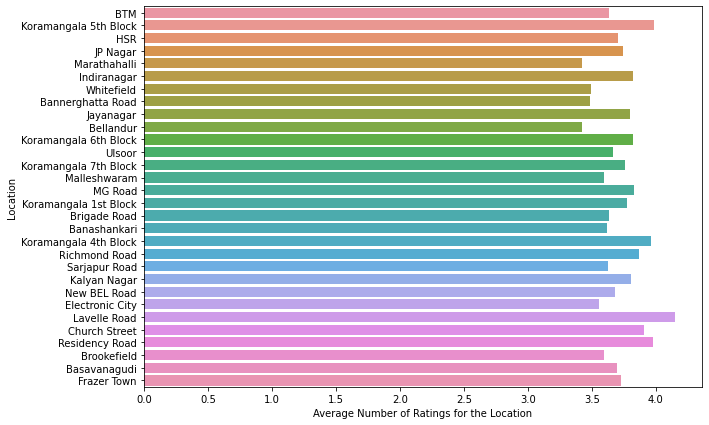

In [18]:
plt.figure(figsize=(10,7))
cuisine_votes = restaurant_data.groupby(['location'])['votes'].agg(['mean', 'count']).sort_values(['count','mean'], ascending=False)[:30]
sns.barplot(x=cuisine_votes['mean'], y=cuisine_votes.index)
plt.xlabel('Average Number of Votes for the Location')
plt.ylabel('Location')
plt.show()
plt.figure(figsize=(10, 7))
cuisine_ratings = restaurant_data[['location', 'rate']].dropna()
cuisine_ratings['rate'] = cuisine_ratings['rate'].apply(lambda x: x.split('/')[0]).apply(removeJunk)
cuisine_ratings = cuisine_ratings.groupby('location')['rate'].agg(['mean', 'count']).sort_values(['count', 'mean'], ascending=False)[:30]
sns.barplot(x=cuisine_ratings['mean'], y=cuisine_ratings.index)
plt.xlabel('Average Number of Ratings for the Location')
plt.ylabel('Location')
plt.show()